In [1]:
%pip install -r requirements.txt
#%pip uninstall -y tinarm
%pip install -e ../.


Note: you may need to restart the kernel to use updated packages.
Obtaining file:///Users/martinwest/Repositories/Lonely-Tool-Cult/tinarm
  Preparing metadata (setup.py) ... done
  Attempting uninstall: tinarm
    Found existing installation: tinarm 0.1
    Uninstalling tinarm-0.1:
      Successfully uninstalled tinarm-0.1
  Running setup.py develop for tinarm
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import pint_pandas
import logging
import tinarm
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [3]:
### Configure Logging
LOGGING_LEVEL = logging.INFO

logger = logging.getLogger()
logger.setLevel(LOGGING_LEVEL)
logger.info(f"tinarm version {tinarm.__version__}")
logger.info(f"pint_pandas version {pint_pandas.__version__}")

q = pint_pandas.PintType.ureg
q.setup_matplotlib()

2024-03-22 02:15:43,927 - NoJobId - INFO - Martins-MacBook-Air.local - 194884122.py-><module>() - tinarm version 0.1
2024-03-22 02:15:43,928 - NoJobId - INFO - Martins-MacBook-Air.local - 194884122.py-><module>() - pint_pandas version 0.5


In [4]:
# Get the operating points for the machine machine='M1'
# Each opperating point is a folder in the machine folder
machine = 'M1'
operating_points = [op_point for op_point in os.listdir(machine) if os.path.isdir(os.path.join(machine, op_point)) and not op_point.startswith('__pycache__')]

In [5]:
_units = {("EMFa", "X"):q.degrees,
         ("EMFa", "Y"):q.V,
         ("EMFb", "X"):q.degrees,
         ("EMFb", "Y"):q.V,
         ("EMFb2", "X"):q.degrees,
         ("EMFb2", "Y"):q.V,
         ("EMFc", "X"):q.degrees,
         ("EMFc", "Y"):q.V,
         ("Ia", "X"):q.degrees,
         ("Ia", "Y"):q.A,
         ("Ib", "X"):q.degrees,
         ("Ib", "Y"):q.A,
         ("Ic", "X"):q.degrees,
         ("Ic", "Y"):q.A, 
         ("Torque", "X"):q.degrees,
         ("Torque", "Y"):q.N*q.m, 
         ("Va", "X"):q.degrees,
         ("Va", "Y"):q.V,
         ("Vb", "X"):q.degrees,
         ("Vb", "Y"):q.V,
         ("Vc", "X"):q.degrees,
         ("Vc", "Y"):q.V}


In [6]:
# check that we have all the expected charts
def check_charts(machine, operating_points):
    expected_charts = ['BackEmf.csv', 'CurrentAngle.csv',
                    'IronLoss.csv', 'MagnetLoss.csv',
                    'PhaseVoltage.csv', 'Torque.csv']
    for op_point in operating_points:
        print(f"Processing {op_point}")
        charts = [c for c in os.listdir(os.path.join(machine, op_point)) if c.endswith('.csv')]
        charts.sort()

        for chart in charts:
            if chart in expected_charts:
                # in green text
                print(f"\033[32m  {chart} found\033[0m")
            else:
                # in red text
                print(f"\033[31m  {chart} not found\033[0m")
        if "operating_point.py" in os.listdir(os.path.join(machine, op_point)):
            print(f"\033[32m  operating_point.py found\033[0m")
        else:
            print(f"\033[31m  operating_point.py not found\033[0m")
    return charts

charts = check_charts(machine, operating_points)



Processing PeakTorqueBaseSpeed_36Nm_1380rpm
  BackEmf.csv found
  CurrentAngle.csv found
  IronLoss.csv found
  MagnetLoss.csv found
  PhaseVoltage.csv found
  Torque.csv found
  operating_point.py not found
Processing Nominal_24Nm_2060rpm
  BackEmf.csv found
  CurrentAngle.csv found
  IronLoss.csv found
  MagnetLoss.csv found
  PhaseVoltage.csv found
  Torque.csv found
  operating_point.py found
Processing NominalPowerMaxSpeed_13Nm_3600rpm
  BackEmf.csv found
  CurrentAngle.csv found
  IronLoss.csv found
  MagnetLoss.csv found
  PhaseVoltage.csv found
  Torque.csv found
  operating_point.py found


In [7]:
from M1 import machine as m
from M1.Nominal_24Nm_2060rpm import operating_point as nominal_op
from M1.NominalPowerMaxSpeed_13Nm_3600rpm import operating_point as max_speed_op

op_point = "NominalPowerMaxSpeed_13Nm_3600rpm"
chart = "BackEmf.csv"


num_phases = m.winding_parameters["number_phases"].to_base_units().magnitude
num_pole_pairs = (m.rotor_parameters["number_poles"]//2).to_base_units().magnitude


In [8]:
# apply the units "pint[degrees]" to the X columns and "pint[V]" to the Y columns
df = pd.read_csv(os.path.join(machine, op_point, chart), index_col=None, header=[0,1])
df.columns = pd.MultiIndex.from_tuples([(l1, l2, _units[(l1,l2)]) for l1,l2 in df.columns])
df_emfs = df.pint.quantify(level=-1)

In [9]:
df_emfs.dtypes

EMFa  X    pint[degree]
      Y      pint[volt]
EMFb  X    pint[degree]
      Y      pint[volt]
EMFc  X    pint[degree]
      Y      pint[volt]
dtype: object

In [10]:
def convert_to_electrical_degrees(ib_df, num_pole_pairs=5, new_name="Current"):
    ib_df['X'] = ib_df['X'].map(lambda x: x * num_pole_pairs) # convert to electrical degrees
    ib_df.rename(columns={"X": "Theta", "Y": new_name}, inplace=True) # rename the columns
    ib_df = ib_df.apply(lambda x: x.pint.to_base_units()) # convert to base units
    return ib_df

EMFa_df =  convert_to_electrical_degrees(df_emfs["EMFa"].copy(),
                                         num_pole_pairs=num_pole_pairs,
                                         new_name="Voltage")
#drop nans and reset index
EMFa_df.dropna(inplace=True)

EMFb_df =  convert_to_electrical_degrees(df_emfs["EMFb"].copy(),
                                         num_pole_pairs=num_pole_pairs,
                                         new_name="Voltage")
#drop nans and reset index
EMFb_df.dropna(inplace=True)

EMFc_df =  convert_to_electrical_degrees(df_emfs["EMFc"].copy(),
                                         num_pole_pairs=num_pole_pairs,
                                         new_name="Voltage")
#drop nans and reset index
EMFc_df.dropna(inplace=True)

In [11]:
def overlay_emf(df, num_phases, num_pole_pairs):
    assert num_phases == 3
    theta_m = np.hstack((np.deg2rad(df['EMFa']['X'] ),
            np.deg2rad((df['EMFb']['X']-(360/num_pole_pairs/num_phases))),
            np.deg2rad((df['EMFc']['X']+(360/num_pole_pairs/num_phases)))))


    v_emf = np.hstack((df['EMFa']['Y'],
                df['EMFb']['Y'],
                df['EMFc']['Y']))

    not_nan  = np.logical_not(np.logical_and(np.isnan(theta_m), np.isnan(v_emf)))
    theta_m = theta_m[not_nan] * num_pole_pairs
    v_emf = v_emf[not_nan]
    sort_idx = np.argsort(theta_m)
    return theta_m[sort_idx], v_emf[sort_idx]

In [12]:
# set the initial guess, coef[0] is the phase offset, the rest are the cosine coefficients
coefs = np.array([np.nan,  np.nan, np.nan, np.nan,
       -9.96330324e-02, -1.11853145e+00, 2.27614394e-01,  2.32197231e-01,
        2.34067377e-01,  5.18779813e-01,  5.52624693e-02, 0, 0 ])
# make odd coefficients, from 1 to 2*len(coefs)-1
n_idx = np.arange(1, 2*len(coefs)-1, 2)

In [13]:
def predict(coefs, theta):
    """
    Predict the EMF given the coefficients and the electrical angle theta
    """
    n_idx = np.arange(1, 2 * len(coefs)-1, 2)
    pred = np.matmul(coefs[1:], np.cos(np.outer(n_idx, coefs[0] + theta)))
    return pred

def loss(coefs, theta, v_emf):
    pred = predict(coefs, theta)
    return np.sum((v_emf - pred)**2)

In [14]:
#optimise the coefficients
theta_m, v_emf = overlay_emf(df, num_phases, num_pole_pairs)
peak_voltage = np.max(v_emf)
#set bounds that the coefficients must be positive
bounds = [(None, None) for _ in range(len(coefs))]
bounds[0] = (0, 2*np.pi/num_pole_pairs)
bounds[1] = (peak_voltage, peak_voltage * 1.5) # fundamental
bounds[2] = (-0.2 * peak_voltage , 0) # 3rd harmonic
bounds[3] = (-0.02 * peak_voltage , 0) # 5th harmonic
bounds[4] = (None , None) # 7th harmonic
bounds[5] = (None , None) # 9th harmonic
bounds[6] = (None , None) # (0.01 * peak_voltage , 0.2 * peak_voltage) # 11th harmonic

coefs[0:4] =np.mean(bounds[0:4], axis=1)
coefs

array([ 6.28318531e-01,  3.38499498e+02, -2.70799598e+01, -2.70799598e+00,
       -9.96330324e-02, -1.11853145e+00,  2.27614394e-01,  2.32197231e-01,
        2.34067377e-01,  5.18779813e-01,  5.52624693e-02,  0.00000000e+00,
        0.00000000e+00])

In [15]:
theta_m, v_emf = overlay_emf(df, num_phases, num_pole_pairs)
res = minimize(loss, coefs,
               args=(theta_m, v_emf),
               method='Nelder-Mead', tol=1e-6,
               bounds=bounds,
               options={'disp': True, "maxiter":9000})
print(res.success)

print(res.x)
back_emf_fit = {"phase_offset": -res.x[0], "coefs": res.x[1:]}

Optimization terminated successfully.
         Current function value: 602.757770
         Iterations: 4323
         Function evaluations: 5908
True
[ 2.17274092e-01  2.89932414e+02 -1.43344688e+01 -4.55514252e+00
 -5.04618632e-01 -4.98193418e-01  6.74392261e-01 -3.43212445e-01
  2.98385714e-01 -4.25465348e-02  6.80754358e-01 -3.79409793e-02
 -1.70002744e-02]


In [16]:
phase_emf_a = back_emf_fit["phase_offset"]
phase_emf_b = back_emf_fit["phase_offset"] +(2*np.pi  / num_phases)
phase_emf_c = back_emf_fit["phase_offset"] +2*(2*np.pi  / num_phases)


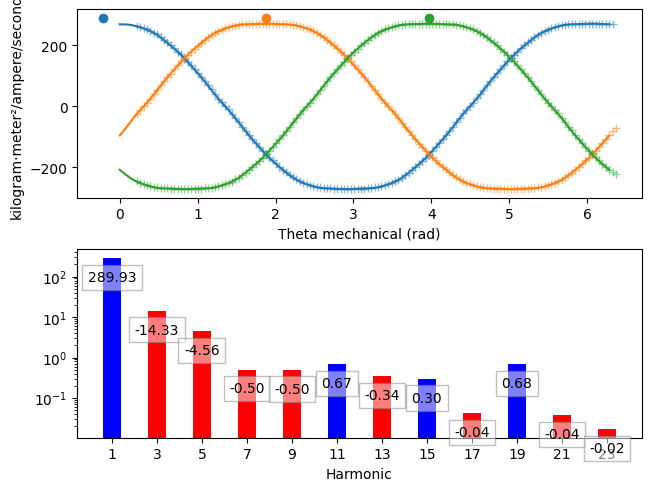

In [17]:
fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
la, = ax_t.plot(EMFa_df['Theta'], EMFa_df['Voltage'], '+', alpha=0.5)
lb, = ax_t.plot(EMFb_df['Theta'], EMFb_df['Voltage'], '+', alpha=0.5)
lc, = ax_t.plot(EMFc_df['Theta'], EMFc_df['Voltage'], '+', alpha=0.5)

theta = np.linspace(0, 2*np.pi, 1000)

ax_t.plot(theta, predict(res.x, theta), color=la.get_color())
ax_t.plot(theta, predict(res.x, theta-(2*np.pi/num_phases)), color=lb.get_color())
ax_t.plot(theta, predict(res.x, theta+(2*np.pi/num_phases)), color=lc.get_color())

ax_t.plot(phase_emf_a, res.x[1], 'o', color=la.get_color())
ax_t.plot(phase_emf_b, res.x[1], 'o', color=lb.get_color())
ax_t.plot(phase_emf_c, res.x[1], 'o', color=lc.get_color())
ax_t.set_xlabel('Theta mechanical (rad)')

ax_w.bar(n_idx, abs(res.x[1:]), color = ['r' if res.x[i] < 0 else 'b' for i in range(1, len(res.x))])
ax_w.set_xlabel('Harmonic')
ax_w.set_yscale('log')
ax_w.set_xticks(n_idx)
for i in range(1, len(res.x)):
    ax_w.text(n_idx[i-1], abs(res.x[i])*0.5, f"{res.x[i]:.2f}", ha='center', va='top', bbox=dict(facecolor='white',
                                                                                                alpha=0.5, edgecolor='gray'))

In [18]:
import yaml
from tinarm import Job
from tinarm import Machine
from tinarm.api import JOB_STATUS, STATUS_JOB
from tinarm import Api
import time

In [19]:
simulation_parameters = {
       "samples_per_electrical_period": 180 * q.count/q.turn,
        "timestep_intervals": 180 * q.count,
        "active_length": 65 * q.mm * 0.95}

In [20]:
with open("configurations.yaml", "r") as f:
    config = yaml.safe_load(f)

In [21]:
open_cct = max_speed_op.operating_point.copy()
open_cct['current_density'] = 0.0 * q.A/q.mm**2
open_cct

{'current_density': 0.0 <Unit('ampere / millimeter ** 2')>,
 'current_angle': 255 <Unit('degree')>,
 'simulated_speed': 3600 <Unit('revolutions_per_minute')>}

In [22]:
api = Api(config["root_url"], config["api_key"], config["org_id"])
m1 = Machine(m.stator_parameters, m.rotor_parameters, m.winding_parameters)

j1 = Job(m1, open_cct, simulation_parameters, title="Open CCT")
j1_result = api.create_job(j1)
j1_result = api.update_job_status(j1.id, JOB_STATUS['QueuedForMeshing'])
init_time = time.time()
while STATUS_JOB[api.get_job(j1.id)['status']] != 'Complete':
    print("{2:2.4} {1} status {0}".format(STATUS_JOB[api.get_job(j1.id)['status']], j1.title, time.time()-init_time))
    time.sleep(10)
time.sleep(1)
print("{2:2.4}s {1} status {0}".format(STATUS_JOB[api.get_job(j1.id)['status']], j1.title, time.time()-init_time))

2024-03-22 02:15:46,669 - NoJobId - INFO - Martins-MacBook-Air.local - api.py->__init__() - root_url: https://api.build.tinarmengineering.com


ConnectTimeout: HTTPSConnectionPool(host='api.build.tinarmengineering.com', port=443): Max retries exceeded with url: /jobs/?apikey=ae85149d1813f3e8add219d522ead63e&org_id=65fb0588b5567614346626ea (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x14f266c90>, 'Connection to api.build.tinarmengineering.com timed out. (connect timeout=None)'))

In [ ]:
j1_result = api.get_job(j1.id)
j1_result_data = [art for art in j1_result['artifacts'] if art['type']=='RESULT_DATA'][0]

if j1_result_data['url'].startswith("http"):
    print("Result data available at", j1_result_data['url'])
    j1_df = pd.read_csv(j1_result_data['url'], header=[0, 1], index_col=[0, 1]).pint.quantify(level=-1)
else:
    print("Result data not available yet. Have you promoted the artifact?")

In [ ]:
#convert all the data in j1_df to base units
j1_df = j1_df.pint.to_base_units()

In [ ]:
theta_err = np.pi + np.deg2rad(4)
angles = j1_df["angles"].pint.magnitude

fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
la, = ax_t.plot(j1_df['angles'], j1_df['Phase_0'], label='Phase A')
lb, = ax_t.plot(j1_df['angles'], j1_df['Phase_1'], label='Phase B')
lc, = ax_t.plot(j1_df['angles'], j1_df['Phase_2'], label='Phase C')

ax_t.plot(j1_df['angles'],
          predict(res.x, angles+theta_err),
          '--',
          alpha=0.5,
          color=la.get_color())
ax_t.plot(j1_df['angles'],
          predict(res.x, angles-(2*np.pi/num_phases)+theta_err),
          '--', alpha=0.5,
          color=lb.get_color())
ax_t.plot(j1_df['angles'],
          predict(res.x, angles+(2*np.pi/num_phases)+theta_err),
          '--', alpha=0.5,
          color=lc.get_color())
          
ax_t.set_xlabel('Theta electrical (rad)')
ax_t.legend()
err = np.sum(np.abs(j1_df['Phase_0'] - (q.V * predict(res.x, angles+theta_err))))
print(f"Error {err}")

# do an fft of the j1_df['Phase_0'] and compare to the coefficients
from scipy.fft import fft
# Number of sample points
N = len(j1_df['Phase_0'])
# sample spacing
delta_theta = np.diff(j1_df['angles'])[0]

yf = fft(j1_df['Phase_0'].values, n=N)
ax_w.bar(x=range(1,24,2), height=np.abs(yf[1:24:2])/(N/2), color='b')
ax_w.bar(n_idx, abs(res.x[1:]), color = 'r', alpha=0.5)
ax_w.set_yscale('log')
for i in range(1, len(res.x)):
    diff = abs(yf[i*2-1]/(N/2)) / abs(res.x[i])
    ax_w.text(n_idx[i-1], abs(yf[i*2-1]/(N/2))*0.5, f"{diff:2.0%}", ha='center', va='top', bbox=dict(facecolor='white',
                                                                                                alpha=0.5, edgecolor='gray'))

In [ ]:
current_df = pd.read_csv(os.path.join(machine, op_point, "CurrentAngle.csv"),
                         index_col=None, header=[0,1])
                      
current_df.columns = pd.MultiIndex.from_tuples([(l1, l2, _units[(l1,l2)]) for l1,l2 in current_df.columns])
current_df = current_df.pint.quantify(level=-1)
ib_df = current_df['Ib']


In [ ]:
ib_df = convert_to_electrical_degrees(current_df['Ib'].copy(), new_name="Current")
ib_df.dropna(inplace=True)
emfb_df = convert_to_electrical_degrees(current_df['EMFb2'].copy(), new_name="EMF_B")


In [ ]:
emfb_df.dropna(inplace=True)

In [ ]:
current_coef = np.array([1.5, 75]) #initial guess offset and amplitude
bounds = [(None, None) for _ in range(len(current_coef))]

def predict_current(coefs, theta):
    """Predict the current from the coefficients and the angle, 
    the coefficients are the phase offset and the amplitude of the cosine function
    the angle is the electrical angle in radians"""
    pred = coefs[1] * np.cos(coefs[0] - theta)
    return pred

def loss_current(coefs, theta, current):
    current_b = predict_current(coefs, theta)
    return np.sum((current - current_b)**2)

res_current = minimize(loss_current, current_coef,
                       args=(ib_df["Theta"].pint.magnitude,
                             ib_df["Current"].pint.magnitude),
                             method='Nelder-Mead',
                             tol=1e-6,
                             bounds=bounds,)
print(res_current)

ib_mag = res_current.x[1]
phase_current_b = res_current.x[0]
print(phase_current_b)

In [ ]:
fig, (ax_t) = plt.subplots(1, 1, constrained_layout=True)

l_emf_b, = ax_t.plot(current_df['EMFb2']['X'].pint.to_base_units().pint.magnitude * num_pole_pairs,
                     current_df['EMFb2']['Y'],
                     'x', alpha=0.5, color=lb.get_color())

ax_right = ax_t.twinx()
l_ib, =  ax_right.plot(current_df['Ib']['X'].pint.to_base_units().pint.magnitude * num_pole_pairs,
                       current_df['Ib']['Y'], '+', alpha=0.5)

ax_t.plot(j1_df['angles'].pint.to_base_units().pint.magnitude,
          predict(res.x, j1_df['angles'].pint.magnitude-(2*np.pi/num_phases)),
          '--',
          color=lb.get_color())

ax_right.plot(ib_df["Theta"].pint.magnitude,
          predict_current(res_current.x, ib_df["Theta"].pint.magnitude),
          color=l_ib.get_color())
ax_right.set_ylabel('Current (A)')


ax_right.plot(phase_current_b, ib_mag, 'o', color=l_ib.get_color())
ax_t.plot(phase_emf_b , res.x[1], 'o', color=lb.get_color())

ax_t.axvline(phase_emf_b , color=lb.get_color(), linestyle='--')
ax_t.axvline(phase_current_b, color=l_ib.get_color(), linestyle='--')

phase_difference = np.rad2deg((phase_current_b - phase_emf_b) )
print(f"Phase difference {phase_difference} degrees")
ax_t.text(phase_current_b, 0, f"{phase_difference:.2f}°", ha='center', va='top', bbox=dict(facecolor='white',
                                                                                                alpha=0.5, edgecolor='gray'))   
ax_t.set_xlabel('Theta electrical (rad)')
#set markers in degrees on the top axis
# add a x-axis spine on top
ax_ttop = ax_t.secondary_xaxis('top')
ax_ttop.set_xlabel('Theta electrical (rad)')
tick_pos = [0, 60, 120, 180, 240, 300, 360]
ax_ttop.set_xticks(np.deg2rad(tick_pos))
ax_ttop.set_xticklabels(tick_pos)
ax_ttop.set_xlabel('Theta electrical (deg)')

In [ ]:
# Do the 2nd simulation

j2 = Job(m1, max_speed_op.operating_point, simulation_parameters, title="nominal")
j2_result = api.create_job(j2)
j2_result = api.update_job_status(j2.id, JOB_STATUS['QueuedForMeshing'])
init_time = time.time()
while STATUS_JOB[api.get_job(j2.id)['status']] != 'Complete':
    print("{2:2.4} {1} status {0}".format(STATUS_JOB[api.get_job(j2.id)['status']], j2.title, time.time()-init_time))
    time.sleep(10)
time.sleep(1)
print("{2:2.4}s {1} status {0}".format(STATUS_JOB[api.get_job(j2.id)['status']], j2.title, time.time()-init_time))


In [ ]:
j2_result = api.get_job(j2.id)
j2_result_data = [art for art in j2_result['artifacts'] if art['type']=='RESULT_DATA'][0]

if j2_result_data['url'].startswith("http"):
    print("Result data available at", j2_result_data['url'])
    j2_df = pd.read_csv(j2_result_data['url'], header=[0, 1], index_col=[0, 1]).pint.quantify(level=-1)
else:
    print("Result data not available yet. Have you promoted the artifact?")

In [ ]:
fig, (ax_t) = plt.subplots(1, 1, constrained_layout=True)

reference_current = predict_current(res_current.x, j2_df["angles"].pint.magnitude).astype('pint[A]')

ax_t.plot(j2_df['angles'], j2_df['Slot_2_Current'], label='Slot 2, A', color=la.get_color())
ax_t.plot(j2_df['angles'], j2_df['Slot_3_Current'], label='Slot 3, b', color=lb.get_color())
ax_t.plot(j2_df['angles'], j2_df['Slot_4_Current'], label='Slot 4, B', color=lb.get_color())
ax_t.plot(j2_df['angles'], j2_df['Slot_7_Current'], label='Slot 7, C', color=lc.get_color())

ax_t.plot(j2_df["angles"],
          reference_current,
          color=lb.get_color(), linestyle='--', linewidth=3, alpha=0.5, label='Phase B')
ax_t.set_ylabel('Current (A)')
ax_t.legend()
print(f"Reference Peak Current {reference_current.max():2.5~P}")
print(f"Simulated Peak Current {j2_df['Slot_4_Current'].max():2.5~P} ")
print(f"Relative Error {100*(reference_current.max()/j2_df['Slot_4_Current'].max())} %")

In [ ]:
torque_df = pd.read_csv(os.path.join(machine, op_point, 'Torque.csv'),
                         index_col=None, header=[0,1])

torque_df.columns = pd.MultiIndex.from_tuples([(l1, l2, _units[(l1,l2)]) for l1,l2 in torque_df.columns])
torque_df = torque_df.pint.quantify(level=-1)

torque_df =  convert_to_electrical_degrees(torque_df["Torque"].copy(),
                                         num_pole_pairs=num_pole_pairs,
                                         new_name="Torque")
#drop nans and reset index
torque_df.dropna(inplace=True)
torque_df

In [ ]:

fig, (ax_t) = plt.subplots(1, 1, constrained_layout=True)
l_torque, = ax_t.plot(torque_df['Theta'], torque_df['Torque'], '-+', alpha=0.5, label='Reference Torque')
l_sim_t, = ax_t.plot(j2_df['angles'], j2_df['Scaled Torque'], label='Simulated Torque') 
ax_t.set_xlabel('Theta electrical (rad)')
ax_t.set_ylabel('Torque (N.m)')
ax_t.legend()
print(f"Reference Average Torque {torque_df['Torque'].mean().to(q.N*q.m):2.5~P}")
print(f"Simulated Average Torque {j2_df['Scaled Torque'].mean():2.5~P} ")
print(f"Relative Error {(torque_df['Torque'].mean() / j2_df['Scaled Torque'].mean()).to(q.percent):2.5~P}")

In [ ]:
voltage_df = pd.read_csv(os.path.join(machine, op_point, 'PhaseVoltage.csv'),
                         index_col=None, header=[0,1])
                         
voltage_df.columns = pd.MultiIndex.from_tuples([(l1, l2, _units[(l1,l2)]) for l1,l2 in voltage_df.columns])
voltage_df = voltage_df.pint.quantify(level=-1)

va_df =  convert_to_electrical_degrees(voltage_df["Va"].copy(),
                                         num_pole_pairs=num_pole_pairs,
                                         new_name="Phase A")
#drop nans and reset index
va_df.dropna(inplace=True)

vb_df =  convert_to_electrical_degrees(voltage_df["Vb"].copy(),
                                         num_pole_pairs=num_pole_pairs,
                                         new_name="Phase B")
#drop nans and reset index
vb_df.dropna(inplace=True)

vc_df =  convert_to_electrical_degrees(voltage_df["Vc"].copy(),
                                         num_pole_pairs=num_pole_pairs,
                                         new_name="Phase C")
#drop nans and reset index
vc_df.dropna(inplace=True)

In [ ]:
fig, (ax_t) = plt.subplots(1, 1, constrained_layout=True)

ax_t.plot(va_df['Theta'], va_df['Phase A'], label='Phase A', color=la.get_color())
ax_t.plot(vb_df['Theta'], vb_df['Phase B'], label='Phase B', color=lb.get_color())
ax_t.plot(vc_df['Theta'], vc_df['Phase C'], label='Phase C', color=lc.get_color())

ax_t.plot(j2_df['angles'], j2_df['Phase_0'], label='Phase A', color=la.get_color(), linestyle='--')
ax_t.plot(j2_df['angles'], j2_df['Phase_1'], label='Phase B', color=lb.get_color(), linestyle='--')
ax_t.plot(j2_df['angles'], j2_df['Phase_2'], label='Phase C', color=lc.get_color(), linestyle='--')